In [2]:
import os
import sys

dir = os.path.abspath('')
parent = os.path.dirname(dir)
if not parent in sys.path:
    sys.path.append(parent)


In [3]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import Compose
from torchvision.transforms import functional as F

from data.custom_celeba import CelebA, xywh2xyxy

import cv2 as cv


In [3]:
training_data = CelebA(
    '../CelebA',
    target_transform=Compose([xywh2xyxy, torch.Tensor.float])
)


## Podatkovni skup


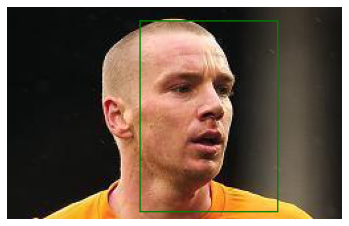

In [4]:
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]

img = F.pil_to_tensor(img)

img = draw_bounding_boxes(img, label.unsqueeze_(0), colors='green', width=img.shape[2]//128)
plt.axis('off')
plt.imshow(F.to_pil_image(img))
plt.show()


## MTCNN


/home/anton/anaconda3/envs/cv2/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


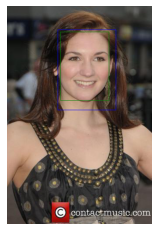

In [5]:
from facenet_pytorch import MTCNN

model = MTCNN()

sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, target = training_data[sample_idx]

pred, _ = model.detect(img)
pred = torch.tensor(pred[0])

bbox = torch.stack((pred, target))

img = F.pil_to_tensor(img)

img = draw_bounding_boxes(img, bbox, colors=['green', 'blue'])
plt.imshow(F.to_pil_image(img))

plt.axis('off')
plt.show()


## Kaskadni klasifikator


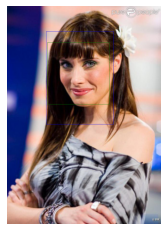

In [6]:
cascade_path = '../cascade/haarcascade_frontalface_alt.xml'

face_cascade = cv.CascadeClassifier()
face_cascade.load(cascade_path)

sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, target = training_data[sample_idx]

img = F.pil_to_tensor(img)

ndarr = img.permute((1, 2, 0)).numpy()
img_gray = cv.cvtColor(ndarr, cv.COLOR_RGB2GRAY)
img_gray = cv.equalizeHist(img_gray)

pred = face_cascade.detectMultiScale(img_gray)
pred = torch.tensor(pred[0])

pred[2] += pred[0]
pred[3] += pred[1]

pred = torch.stack((pred, target))

img = draw_bounding_boxes(img, pred, colors=['green', 'blue'])
plt.axis('off')
plt.imshow(F.to_pil_image(img))
plt.show()

## MyNet

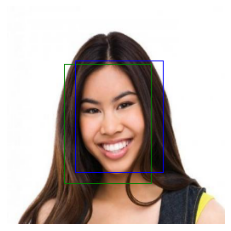

In [55]:
from models.my_net import MyNet

sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, target = training_data[sample_idx]

img = F.to_tensor(img)

w, h = img.shape[1:]
target[0::2] *= 256 / w
target[1::2] *= 256 / h

img = F.resize(img, [256, 256])

model = MyNet()
model.load_state_dict(torch.load('../models/model.pth'))
model.eval()

pred = model(img.unsqueeze_(0))

img = (img.squeeze_(0) * 255).to(dtype=torch.uint8)
pred = pred.squeeze_(0).to(dtype=torch.uint8)

pred = torch.stack((pred, target))

img = draw_bounding_boxes(img, pred, colors=['green', 'blue'])

plt.axis('off')
plt.imshow(F.to_pil_image(img))
plt.show()

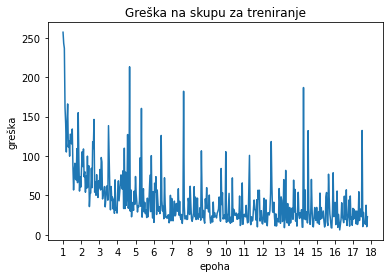

In [113]:
import numpy as np

train_losses = [17732.816406, 16286.016602, 9295.501953, 4601.637695, 1317.222412, 257.202759, 243.105911, 236.788147, 161.580246, 140.994156, 105.087067, 141.307602, 166.127045, 111.314346, 119.032059, 99.780029, 127.679718, 126.846481, 115.400024, 134.314514, 87.054886, 56.862026, 80.918388, 90.772705, 70.622116, 69.606262, 109.396149, 66.159546, 155.022522, 95.284981, 55.467468, 73.350731, 60.524963, 84.65918, 105.357315, 86.542191, 108.959091, 73.641541, 80.066498, 54.031567, 74.48143, 59.106674, 99.834869, 60.94976, 87.703506, 35.754143, 51.741226, 53.185146, 84.425995, 59.72456, 118.206314, 109.543976, 146.447662, 54.094139, 67.045197, 50.160866, 76.335541, 52.789017, 47.315426, 68.584419, 59.51593, 82.850212, 56.854748, 98.101204, 92.507797, 45.464016, 52.205971, 54.28727, 61.216652, 35.400963, 45.87479, 60.647671, 62.273354, 43.913322, 138.577484, 94.541855, 57.325882, 31.655964, 61.291977, 43.546307, 47.843506, 32.675419, 45.242237, 27.181658, 69.731415, 31.187347, 33.536324, 27.463842, 54.536926, 68.450562, 43.058266, 54.541046, 65.573586, 76.017258, 62.541286, 57.924431, 81.213379, 33.320908, 109.950394, 33.209412, 79.551468, 37.412758, 46.770123, 127.240852, 33.68454, 42.598724, 213.311951, 30.043709, 56.972015, 22.773262, 36.342251, 41.099102, 30.992825, 55.319046, 38.560734, 73.975845, 51.879417, 41.684357, 28.894875, 36.761848, 35.510094, 42.997879, 97.697289, 36.250141, 160.46994, 22.316454, 38.02634, 58.370689, 29.112823, 41.145416, 26.812492, 31.786453, 21.83247, 46.485298, 22.775417, 34.766144, 55.527954, 75.584625, 29.391182, 100.485687, 33.429176, 21.196079, 54.79496, 15.680632, 65.457649, 53.978313, 73.770348, 25.729988, 56.851654, 40.966064, 29.915638, 35.604519, 26.828794, 32.751396, 126.110001, 43.563198, 30.173405, 36.090572, 20.320557, 72.311813, 39.123344, 22.058882, 22.532711, 20.873001, 24.544453, 25.387478, 15.17132, 18.526094, 50.063896, 17.779884, 46.117237, 20.007938, 17.675192, 31.706236, 42.70295, 23.913235, 25.074142, 39.747131, 30.639511, 29.838661, 58.381081, 24.881287, 42.404305, 22.49107, 19.377398, 25.787075, 14.354115, 25.150305, 182.268372, 36.173386, 20.12801, 20.245007, 24.060421, 19.37026, 19.764992, 46.318176, 40.328491, 25.714035, 61.60376, 38.115513, 20.174438, 17.011326, 21.421848, 27.689241, 61.044048, 22.88726, 47.738697, 19.288822, 24.16745, 46.511322, 19.679516, 25.82169, 22.553205, 34.379463, 18.503815, 106.539665, 51.524994, 21.720695, 30.888174, 18.510647, 14.673424, 45.642406, 33.930641, 59.821106, 33.287811, 36.747597, 28.90991, 50.417286, 22.88168, 14.734953, 21.40509, 24.015215, 16.149725, 41.546768, 22.023964, 28.08658, 24.030054, 23.107372, 21.37364, 27.542675, 29.491552, 32.878876, 47.985298, 26.833157, 17.156818, 84.15625, 38.256477, 53.434792, 19.92758, 22.863823, 25.155437, 20.085556, 105.507477, 15.818916, 25.69652, 16.644852, 36.159653, 52.530548, 17.755251, 14.571274, 22.498571, 15.68634, 72.204681, 16.977386, 32.305496, 29.976223, 24.626778, 26.733814, 27.466105, 19.690147, 19.752584, 26.660685, 20.703211, 49.180588, 11.694125, 13.266264, 32.24564, 65.812943, 13.246346, 21.729624, 25.810745, 25.841681, 22.713448, 37.321293, 22.556557, 15.116179, 15.993221, 59.82552, 100.781708, 18.30629, 12.748067, 22.752571, 17.360237, 18.344345, 32.480305, 44.093674, 32.708702, 29.942722, 18.508945, 44.509361, 10.019438, 56.637703, 45.234562, 56.563805, 17.350281, 21.583988, 30.527889, 14.926928, 13.682512, 23.720867, 46.379044, 15.970814, 16.248856, 44.285202, 14.769453, 11.387252, 28.077988, 27.577913, 25.114098, 30.308344, 52.295311, 118.385117, 62.113102, 29.929382, 28.322113, 41.316399, 21.735855, 11.274802, 26.523794, 11.048372, 19.316006, 20.687389, 16.245567, 58.649635, 41.066513, 14.509241, 48.090141, 43.548378, 16.75004, 19.373913, 70.014633, 8.968572, 28.282211, 81.73291, 18.9891, 15.161742, 39.599197, 14.668505, 11.866362, 34.631729, 14.807999, 15.885752, 33.416382, 33.609978, 19.625584, 69.355164, 28.892012, 57.559013, 17.302639, 26.588696, 10.94239, 30.433155, 53.91571, 24.934311, 20.650038, 28.032051, 21.847816, 31.806602, 9.691408, 9.532772, 186.979736, 20.178102, 57.268341, 19.198664, 29.253475, 26.683512, 14.956896, 132.21048, 33.53318, 19.553709, 13.184398, 27.412464, 70.236511, 32.770569, 10.770825, 9.969745, 21.503387, 34.551903, 21.464676, 18.187714, 34.712082, 15.049459, 16.012259, 29.31846, 13.240381, 52.938946, 19.737326, 34.493191, 20.853733, 25.288696, 30.150175, 17.709311, 9.799276, 12.767532, 47.939789, 53.632603, 16.302011, 11.79047, 76.884003, 47.174728, 26.371284, 18.54154, 8.953776, 8.543974, 31.717573, 78.712662, 23.007719, 38.204414, 41.1259, 12.884599, 15.959283, 55.534119, 9.343231, 25.841595, 17.029188, 6.125608, 13.22068, 19.716225, 40.583447, 22.654602, 20.016209, 15.326481, 48.993591, 19.12409, 29.169825, 57.0285, 11.79604, 20.061636, 25.786791, 44.146965, 10.944518, 49.225922, 19.575802, 22.102762, 11.981944, 33.489151, 19.77663, 32.23896, 20.76016, 29.968117, 13.730639, 30.118324, 13.028896, 18.379402, 54.596268, 18.091469, 32.779015, 26.990517, 22.963484, 132.45192, 10.327139, 28.380777, 14.89609, 15.566925, 13.188201, 37.498421, 10.182189, 22.920628]
test_losses = [17849.574444, 95.23137, 61.9518, 45.171713, 41.819952, 38.258886, 36.084073, 35.844424, 37.697368, 33.474128, 29.115623, 27.671059, 29.660079, 27.458914, 27.460522, 26.248866, 25.948736, 29.251731, 27.551108]

fig, ax = plt.subplots()

ax.plot(train_losses[5:])
ax.set_xticks(np.linspace(0, len(train_losses), 18), range(1, 19))
ax.set_xlabel('epoha')
ax.set_ylabel('greška')
ax.set_title('Greška na skupu za treniranje')

plt.show()

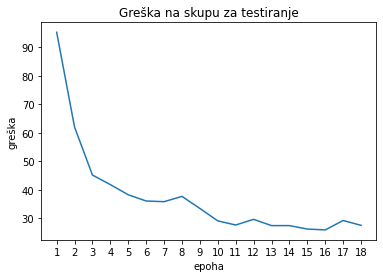

In [93]:
fig, ax = plt.subplots()
ax.plot(test_losses[1:])
ax.set_xticks(range(18), range(1, 19))
ax.set_xlabel('epoha')
ax.set_ylabel('greška')
ax.set_title('Greška na skupu za testiranje')

plt.show()